In [1]:
using Plots, LinearAlgebra,Interpolations, Random, Distributions, Roots, NLopt, ForwardDiff, LaTeXStrings, DifferentialEquations
gr() #Load in packages
a=zeros(3);
k1=0.1; k2=0.1; p=0.3; #Parameter estimates
T=LinRange(0,20,11);
Tf=LinRange(0,20,1001);
σ=3.0;

In [2]:
function DE!(dx,x,p,t) #Set up differential equation
k1,k2,p=p
dx[1]=-(k1+k2)*x[1]+p
end

DE! (generic function with 1 method)

In [3]:
function odesolver(T,k1,k2,p) #Solve ODE
p=(k1,k2,p)
x0=100.0;
tspan=(0.0,maximum(T));
prob=ODEProblem(DE!,[x0],tspan,p);
sol=solve(prob,saveat=T);
return sol[1,:]
end

odesolver (generic function with 1 method)

In [4]:
function model(T,a) #Solve ODE
y = Vector{eltype(a)}(undef, length(T))
y=odesolver(T,a[1],a[2],a[3])
return y
end

model (generic function with 1 method)

In [5]:
data=zeros(length(T));
#data0=zeros(length(T))
#data0=model(T,[0.1,0.1,1.0])
#data=data0 + σ*randn(length(T))
data = [100.0
  67.40781240523978
  50.36739678330086
  28.639536169059387
  19.515392344072495
  14.371202354712407
  14.76153414167794
  10.755562239200433
   7.889196085316499
   7.604215329108149
   5.187073566537364]; #Store data generated with p=1.0, k1=k2=0.1

In [6]:
function loglhood(data,a,T,σ)  #Additive Gaussian loglikelihood function
y=zeros(length(T)) 
y=model(T,a)
ℓ=0.0
data_dists=[Normal(0,σ) for mi in y];
ℓ+=sum([loglikelihood(data_dists[i],data[i] - y[i]) for i in 1:length(data_dists)]) 
return ℓ
end;

In [7]:
function funmle(a) #Evaluate the loglikelihood
return loglhood(data,a,T,σ)
end;

In [8]:
function Optimise(fun,θ₀,lb,ub)  #Numerical optimization with NLopt and Nelder-Mead
tomax=(θ,∂θ)->fun(θ)
opt=Opt(:LN_NELDERMEAD,length(θ₀))
opt.max_objective=tomax
opt.lower_bounds=lb      
opt.upper_bounds=ub
optmaxtime=1*60
res = optimize(opt,θ₀)
return res[[2,1]]
end;

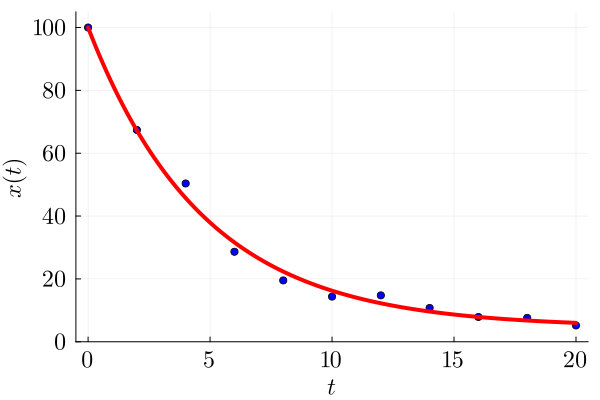

In [9]:
θG=[k1,k2,p] #Parameter estimates
lb=[-10,-10,-10]; ub=[10,10,10] #Parameter bounds
(xopt,fopt)=Optimise(funmle,θG,lb,ub) #Compute optimization
k1mle=xopt[1]; k2mle=xopt[2]; pmle=xopt[3]; fmle = fopt; #Store results
xmle=model(Tf,xopt);
p1=scatter(T,data,mc=:blue,msc=:match,label=false)
p1=plot!(Tf,xmle,lw=4,lc=:red,label=false,xlabel=L"t",ylabel=L"x(t)",xlims=(0,maximum(T)))
p1=plot!(xlims=(0-0.5,maximum(T)+0.5),xticks=([0,5,10,15,20],[L"0",L"5",L"10",L"15",L"20"]))
p1=plot!(ylims=(0,105),yticks=([0,20,40,60,80,100],[L"0", L"20", L"40",L"60",L"80",L"100"]))
p1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)
display(p1)
#savefig(p1,"ProductionDecay_MLE.pdf")

In [10]:
xopt

3-element Vector{Float64}:
 0.10467362471172302
 0.10558603175375833
 0.9659801194577131

In [11]:
ff(θ1,θ2,θ3) = funmle([θ1,θ2,θ3]) #Compute the observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> ff(z[1],z[2],z[3]),xopt)

3×3 Matrix{Float64}:
 17569.6    17569.6    -471.188
 17569.6    17569.6    -471.188
  -471.188   -471.188    17.5662

In [12]:
rank(H) #Compute the rank of the observed Fisher Information

2

In [13]:
(evals,evecs)=eigen(H) #Compute the eigenvectors and eigenvalues of the observed Fisher Information

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
     0.0
     4.927930769219529
 35151.74817598437
vectors:
3×3 Matrix{Float64}:
  0.707107  0.0134087  -0.70698
 -0.707107  0.0134087  -0.70698
  0.0       0.99982     0.0189627

In [14]:
N=50 #Set up grids and bounds for the univariate profile likelihood function computation
k1min=-0.5; k1max=0.6;
k2min=-0.5; k2max=0.6;
pmin=-0.5; pmax=3.0;
kk1=LinRange(k1min,k1max,N);
kk2=LinRange(k2min,k2max,N);
pp=LinRange(pmin,pmax,N);

In [15]:
#Univariate Profiles
df=1
llstar=-quantile(Chisq(df),0.95)/2;

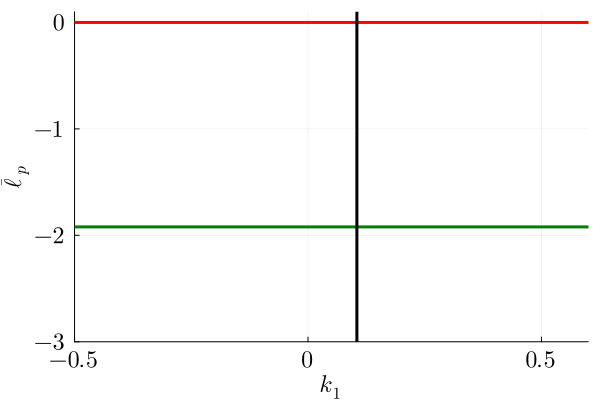

In [16]:
#Function to define univariate profile for k1
function Uk1(k1)
a=zeros(2)    
function funk1(a)
return loglhood(data,[k1,a[1],a[2]],T,σ) 
end
θG=[k2mle,pmle]
lb=[-2,-2]
ub=[10,10]
(xopt,fopt)=Optimise(funk1,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fk1(x) = Uk1(x)[1]

q1=plot(fk1,kk1,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q1=hline!([llstar],legend=false,lw=3,lc=:green)
q1=vline!([k1mle],lc=:black,legend=false,xlabel=L"k_1",ylabel=L"\bar{\ell}_p",lw=3)
q1=plot!(xlims=(minimum(kk1),maximum(kk1)),xticks=([-0.5, 0, 0.5],[L"-0.5",L"0",L"0.5"]))
q1=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

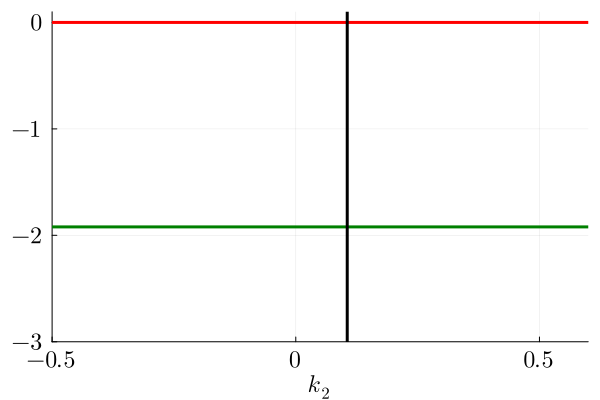

In [17]:
#Function to define univariate profile for k2   
function Uk2(k2)
a=zeros(2)    
function funk2(a)
return loglhood(data,[a[1],k2,a[2]],T,σ) 
end
θG=[k1mle,pmle]
lb=[-2,-2]
ub=[10,10]
(xopt,fopt)=Optimise(funk2,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fk2(x) = Uk2(x)[1]

q2=plot(fk2,kk2,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q2=hline!([llstar],legend=false,lw=3,lc=:green)
q2=vline!([k2mle],lc=:black,legend=false,xlabel=L"k_2",lw=3)
q2=plot!(xlims=(minimum(kk2),maximum(kk2)),xticks=([-0.5, 0, 0.5],[L"-0.5",L"0",L"0.5"]))
q2=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q2=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

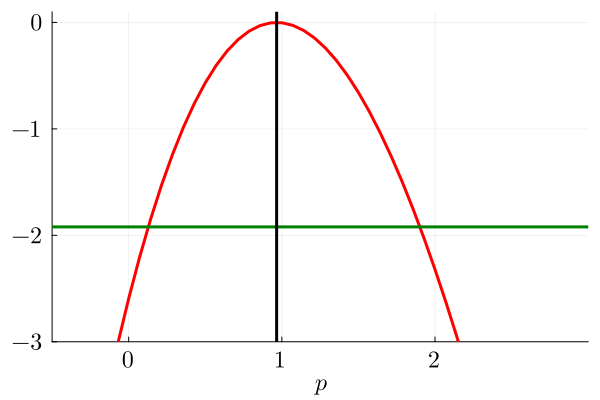

In [18]:
#Function to define univariate profile for p   
function Up(p)
a=zeros(2)    
function funp(a)
return loglhood(data,[a[1],a[2],p],T,σ) 
end
θG=[k1mle,k2mle]
lb=[-2,-2]
ub=[10,10]
(xopt,fopt)=Optimise(funp,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fp(x) = Up(x)[1]
q3=plot(fp,pp,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q3=hline!([llstar],legend=false,lw=3,lc=:green)
q3=vline!([pmle],lc=:black,legend=false,xlabel=L"p",lw=3)
q3=plot!(xlims=(minimum(pp),maximum(pp)),xticks=([0, 1, 2],[L"0",L"1",L"2"]))
q3=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q3=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

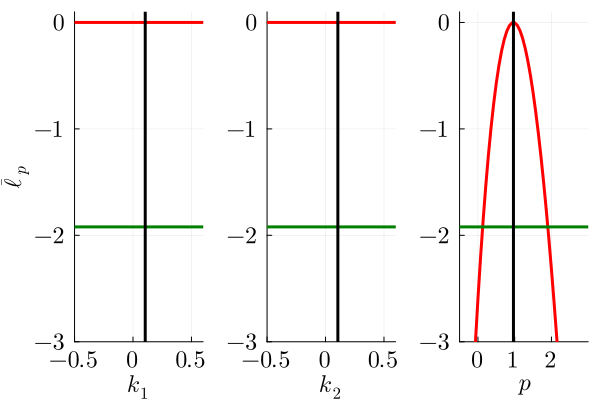

In [19]:
q4=plot(q1,q2,q3,layout=(1,3))
display(q4)
#savefig(q4,"ProductionDecay_Profiles.pdf")

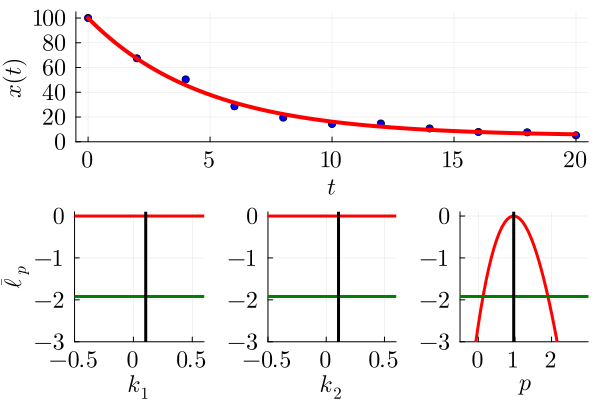

"C:\\Users\\matth\\Dropbox\\Model_Reduction\\Jupyter Notebooks\\Figure1.pdf"

In [20]:
s1=plot(p1,q4,layout=(2,1))
display(s1)
savefig(s1,"Figure1.pdf")